# CIMR GRASP

> This notebook describes the logic behind the CIMR GRASP --- our custom Python-based module to preprocess CIMR antenna patterns into suitable format accepted by CIMR RGB. 

# Table of Contents
- [Standardised Format for the Antenna Patterns ](#Standardised-Format-for-the-Antenna-Patterns)
  - [Parsed Patterns](#Parsed-Patterns)
  - [Preprocessed Patterns](#Preprocessed-Patterns)
- [CIMR GRASP](#Cimr-Grasp)

## Standardised Format for the Antenna Patterns 

CIMR RGB is a software that can work with several different data sets (e.g., CIMR and SMAP) and is designed to be extensible for more. These experiments share some similarities but still rely on a different data formats and conventions throughout their development and operational lifecycles. Therefore, there was a need to develop the standard format for the antenna patterns, which are then ingested into the RGB module. To define this standard, we used SMAP patterns as our baseline. For more information about SMAP patterns see [L1-L3 Ancilliary Products](https://nsidc.org/sites/default/files/smap_anc_l1l3l4.pdf). Specifically, the bottom of page 6. 

### Parsed Patterns

The general naming convention for the _parsed_ patterns is as follows
```
CIMR-OAP-BK-C1-UVv0.1.0.h5 
```
where
- `CIMR` is the name of the experiment (can be e.g., SMAP).
- `OAP` stands for the Original Antenna Pattern. Can also be `PAP` which means Preprocessed Antenna Pattern. The difference is that the latter is the interpolation of the original pattern onto rectilinear grid. 
- `BK` stands for Backward (i.e., the Back-Half space of the pattern). Other possible value is `FR` (i.e., Forward or Front-Half Space of the pattern). 
- `C1` is the horn name and number
- `UV` stands for $(u,v)$ grid. Alternatively, it can be `TP` which stands for $(\theta, \phi)$ grid. 
- `v0.1.0` is the version number 

It contains the following fields
```
/                        Group
/Gain                    Group
/Gain/G1h                Dataset {2501, 2501}	-	H-pol, Co-pol component, real part 
/Gain/G1v                Dataset {2501, 2501}	- 	V-pol, Co-pol component, real part
/Gain/G2h                Dataset {2501, 2501}	- 	H-pol, Co-pol component, imagine part
/Gain/G2v                Dataset {2501, 2501}	- 	V-pol, Co-pol component, imagine part
/Gain/G3h                Dataset {2501, 2501}	-	H-pol, Cross-pol component, real part
/Gain/G3v                Dataset {2501, 2501}	-	V-pol, Cross-pol component, real part
/Gain/G4h                Dataset {2501, 2501}	-	H-pol, Cross-pol component, imagine part
/Gain/G4v                Dataset {2501, 2501}	-	V-pol, Cross-pol component, imagine part
/Grid                    Group
/Grid/dx                 Dataset {SCALAR}
/Grid/dy                 Dataset {SCALAR}
/Grid/nx                 Dataset {SCALAR}
/Grid/ny                 Dataset {SCALAR}
/Grid/u                  Dataset {2501}
/Grid/v                  Dataset {2501}
/Grid/xcen               Dataset {SCALAR}
/Grid/xs                 Dataset {SCALAR}
/Grid/ycen               Dataset {SCALAR}
/Grid/ys                 Dataset {SCALAR}
/Version                 Dataset {SCALAR}	-	file version
```

### Preprocessed Patterns

The _preprocessed_ version hence will be: 
```
CIMR-PAP-BK-C1-TPv0.1.0.h5 
```
where
```
/                        Group
/Gain                    Group
/Gain/G1h            	 Dataset {3600, 900}	-	H-pol, Co-pol component, real part 
/Gain/G1v            	 Dataset {3600, 900}	- 	V-pol, Co-pol component, real part
/Gain/G2h            	 Dataset {3600, 900}	- 	H-pol, Co-pol component, imagine part
/Gain/G2v            	 Dataset {3600, 900}	- 	V-pol, Co-pol component, imagine part
/Gain/G3h            	 Dataset {3600, 900}	-	H-pol, Cross-pol component, real part
/Gain/G3v            	 Dataset {3600, 900}	-	V-pol, Cross-pol component, real part
/Gain/G4h            	 Dataset {3600, 900}	-	H-pol, Cross-pol component, imagine part
/Gain/G4v            	 Dataset {3600, 900}	-	V-pol, Cross-pol component, imagine part
/Grid                	 Group
/Grid/phi            	 Dataset {3600}		- 	phi grid points
/Grid/theta          	 Dataset {900}		-	theta grid points
/Version                 Dataset {SCALAR}	-	file version
```

[__Note__]: To see the structure of hdf5 file use: 
```
$ h5ls -r CIMR-OAP-BK-C1-TP.h5 
```

The standalone module that produces the antenna patterns in the common format is called CIMR GRASP and is described below. 

## CIMR GRASP

The executable to convert the antenna patterns is located inside `src/cimr_grasp/__main__.py`. However, if you install the code, when it is called `cimr-grasp` and should be callable wherever you see fit as long as you configured python virtual environment. 

In a nutshell, it works as follows: 

1. _Parses antenna patterns_ located inside `dpr/AP` and outputs the resulting files (described above) in HDF5 format into `output/parsed`.
2. _Performs beam recentering_ (based off the max gain values of Ghh component). The recentering is optional and is controlled by one of the parameters in the parameter file.
3. Creates a coarser grid in $\left(\theta, \phi\right)$ with a given resolution (default value is  0.1 degrees for each angle), converts this grid into $\left(x, y\right)$ and interpolates original patterns  defined on $\left(u, v\right)$- into $\left(x, y\right)$-grid.
4. Saves resulting patterns (together with $\left(\theta, \phi\right)$ grid values) into HDF5 format (also described above).  

The execution is controlled by parameter file (which can be found inside `configs/grasp_config.xml` of CIMR RGB repo). We recommend to copy this file and modify its parameters however you see fit. However, for testing purposes, we usually created the `AP` directory inside `dpr` and put the original antenna patterns there. 

[**Note**]: The `cimr-grsp` executable expects specific structure for the antenna patterns. Each pattern should get a directory for each band, i.e., if you want to run the code on L and C bands only, you will have to create the following directories (inside `/` of the repo): 
```
dpr/AP/L
dpr/AP/C
```
and put the corresponding antenna patterns inside of these directories. 

In practice, just go to S[&]T Google Drive for CIMR RGB and fetch [the archives (from here)](https://drive.google.com/drive/folders/17mhlrODuXrmlFvnhOpomt28p2WhZ3S84?usp=sharing) of patterns you want to parse and then unpack them inside `dpr/AP` and the aforementioned directories should be automatically created. 

### Chunking 

Since the beam files produced by GRASP TICRA software are pretty large, it is quite possible to run out of RAM while running the interpolation step on a laptop. Therefore, to avoid this issue, we have implemented the following chunking strategy:  

Divide the original grid into given number of chunks and perform interpolation on those chunks one by one (left to write, down to up). The downscaled grid, obviously will have less data points (will be coarser), and it is also not rectilinear. The former is not a problem since the grid borders should stay the same, meaning that the first (the last) chunk will start (end) at the same grid point as the chunk in original grid. This, obviously works for borders only. This leftover data is treated as another chunk. 

The second issue is more complicated. Since the downscaled grid is not rectilinear, the gain value that correspond to the original grid will be scattered around in downscaled grid. Therefore, we need to define a mask, that will detect whether the given data points fall within the given downscaled chunk. In such a way, the original gain values' locations will correspond to the gain values' locations on the downscaled grid.

During interpolation however, one more issue arises --- noisiness of the data on the border of the chunk. To battle this one, we defined the "overlap margin" (which by default amounts to 10%) of the chunk. In this way, we are using only 90% of the original data for a given chunk, but `scipy` interpolation will behave as expected. Obviously, such approach will create a discontinuity on the border between each consecutive chunk. Therefore, we have to shift each consecutive chunk to the left (up; see `chunk_shift_col` and `chunk_shift_row` variables) for a given amount plus the size of the margin. See the picture to get the idea. 




In addition, it is very possible that the original grid cannot be split into equal number of chunks, which will result in some leftover data. So, overall, we will get `num_chunks + 1` to loop over for each row and column. 

To demonstrate these ideas, here is a sample code that simulates some "temperature" from a given complex function and data points. The code is then run in chunks, and compared to the one from using `scipy` on the whole data array. 

In [1]:
import pathlib as pb 
import time 
import pdb 

import numpy as np 
from scipy.interpolate import LinearNDInterpolator, griddata
import matplotlib.pyplot as plt

np.random.seed(56)

n_rows = 1000
n_cols = 1000
# Generate random non-rectilinear grid points and temperature values (10,000 by 10,000)
x_lin = np.linspace(-1.1, 1, n_rows)
y_lin = np.linspace(-1.1, 1, n_cols)
X, Y = np.meshgrid(x_lin, y_lin)
temperature = -(X**2 + Y**2) - 1j * X

# New grid
theta = np.linspace(0, 90, 100)
phi   = np.linspace(0, 360, 100)
theta_grid, phi_grid = np.meshgrid(theta, phi)
# Its cartesian representation 
x_down = np.ravel(np.sin(theta_grid) * np.cos(phi_grid))
y_down = np.ravel(np.sin(theta_grid) * np.sin(phi_grid))
temp_down = np.zeros_like(x_down, dtype = complex) 

Chunked version

In [2]:
start_time_tot = time.perf_counter() 

# Divide the total grid into 4 chunks (25%)
num_chunks = 4
# To avoid discontinuities we define the overlap margin and chunk our code appropriately 
# the margine is 10% for now 
overlap_margin = 0.1 #0.1 #1 #0.01 

# Defining the size of a chunk based of the number provided 
chunk_size_row = n_rows // num_chunks 
chunk_size_col = n_cols // num_chunks 

# We will have to shift to left (and up) everything after the first chunk to properly stitch them together 
chunk_shift_row = 0 
chunk_shift_col = 0

x_min_list = [None] * (num_chunks + 1)
x_max_list = [None] * (num_chunks + 1)

y_min_list = [None] * (num_chunks + 1)
y_max_list = [None] * (num_chunks + 1)

# Creating a loop over all chunks + some leftover values 
for i in range(0, num_chunks + 1, 1):  
    # Calculating the start value for the chunk for the current row based on the chunk size
    if i < num_chunks: 
        start_val_row  = i * chunk_size_row - chunk_shift_row
        end_val_row    = (i + 1) * chunk_size_row - chunk_shift_row
    else: 
        start_val_row  = i * chunk_size_row - chunk_shift_row
        end_val_row    = len(x_lin) #- 1
        
    for j in range(0, num_chunks + 1, 1): 
        if j < num_chunks:
            #if chunk_size_row - chunk_shift_row != 0: 
            print(f"chunk_size_row = {chunk_size_row}")
            #print(f"chunk_percent_to_subtract  = {overlap_margin * chunk_size_row}")
            print(f"chunk_shift_row = {chunk_shift_row}")
            print(f"chunk_size_row - chunk_shift_row = {chunk_size_row - chunk_shift_row}")
            
            # Creating chunks from the original grid X, Y 
            start_val_col  = j * chunk_size_col - chunk_shift_col
            end_val_col    = (j + 1) * chunk_size_col - chunk_shift_col
            
        else: 
            start_val_col  = j * chunk_size_col - chunk_shift_col
            end_val_col    = len(y_lin) 
            
        
        print(f"start_val_col = {start_val_col}, end_val_col = {end_val_col}")
        print(f"start_val_row = {start_val_row}, end_val_row = {end_val_row}")
        
        x_origin_chunk = X[start_val_row:end_val_row, start_val_col:end_val_col]
        y_origin_chunk = Y[start_val_row:end_val_row, start_val_col:end_val_col]
        temp_chunk     = temperature[start_val_row:end_val_row, start_val_col:end_val_col]
            
        # The grid boundaries should stay the same regaraless of the amount of chunks we choose, 
        # because we are downsampling the grid (making it coarser; have less values). Thus, we can
        # define the boundaries for the first chunk in the following manner.
        
        # The issue here is that the values are not exactly matching, so some small amount of points is lost. 
        # So, it makes sense to create a list of values to retrieve later on
        if j == 0:  
            x_min_list[j] = x_origin_chunk.min() 
            x_max_list[j] = x_origin_chunk.max() - overlap_margin * chunk_size_row * np.abs(x_lin[-1] - x_lin[0]) / n_rows
        elif j == num_chunks: 
            x_min_list[j] = x_max_list[j-1] 
            x_max_list[j] = x_origin_chunk.max() 
        else: 
            x_min_list[j] = x_max_list[j-1]
            x_max_list[j] = x_origin_chunk.max() - overlap_margin * chunk_size_row * np.abs(x_lin[-1] - x_lin[0]) / n_rows 
        
        if i == 0: 
            y_min_list[i] = y_origin_chunk.min() 
            y_max_list[i] = y_origin_chunk.max() - overlap_margin * chunk_size_col * np.abs(y_lin[-1] - y_lin[0]) / n_cols 
        elif i == num_chunks: 
            y_min_list[i] = y_max_list[i-1] 
            y_max_list[i] = y_origin_chunk.max() 
        else:
            y_min_list[i] = y_max_list[i-1]
            y_max_list[i] = y_origin_chunk.max() - overlap_margin * chunk_size_col * np.abs(y_lin[-1] - y_lin[0]) / n_cols 
        
        # Now, since the resulting grid is non-rectilinear, the interpolated values are scattered 
        # around the downscaled grid. Therefore, we need to define the mask which will capture those
        # temperature values within the chunk of new grid. 
        mask    = (x_down >= x_min_list[j]) * (x_down <= x_max_list[j]) * (y_down >= y_min_list[i]) * (y_down <= y_max_list[i])
    
        # The grid coordinates from the new/downscaled grid that will correspond to the temperature values 
        x_down_chunk_cropped = x_down[mask]
        y_down_chunk_cropped = y_down[mask]
        
        # Flatten the arrays to get the coordinates and temperature values as 1D arrays
        original_grid_points_chunk = np.vstack([x_origin_chunk.ravel(), y_origin_chunk.ravel()]).T
        # Getting the chunked temperature values into appropriate format
        temp_chunk = temp_chunk.ravel()
        # Interpolating given temperature chunk (portion)
        start_time = time.perf_counter()
        temp_down_chunk = griddata(original_grid_points_chunk, temp_chunk, (x_down_chunk_cropped, y_down_chunk_cropped), method='linear')
        # Saving the interpolated portion into the main temperature array
        temp_down[mask] = temp_down_chunk
        print(f"mask true length {len(mask[mask == True])}")
        end_time = time.perf_counter() - start_time
        print(f"i = {i}, j = {j} took: {end_time:0.2f}s")
    
        # shifting the array to the left 
        chunk_shift_col = int(chunk_shift_col + 2 * overlap_margin * chunk_size_col)

    # Updating the row element and starting anew for the column shift 
    chunk_shift_row = int(chunk_shift_row + 2 * overlap_margin * chunk_size_row)
    chunk_shift_col = 0

end_time_tot = time.perf_counter() - start_time_tot
print(f"It took: {end_time_tot:0.2f}s")

chunk_size_row = 250
chunk_shift_row = 0
chunk_size_row - chunk_shift_row = 250
start_val_col = 0, end_val_col = 250
start_val_row = 0, end_val_row = 250
mask true length 69
i = 0, j = 0 took: 62.07s
chunk_size_row = 250
chunk_shift_row = 0
chunk_size_row - chunk_shift_row = 250
start_val_col = 200, end_val_col = 450
start_val_row = 0, end_val_row = 250
mask true length 365
i = 0, j = 1 took: 68.27s
chunk_size_row = 250
chunk_shift_row = 0
chunk_size_row - chunk_shift_row = 250
start_val_col = 400, end_val_col = 650
start_val_row = 0, end_val_row = 250
mask true length 462
i = 0, j = 2 took: 53.33s
chunk_size_row = 250
chunk_shift_row = 0
chunk_size_row - chunk_shift_row = 250
start_val_col = 600, end_val_col = 850
start_val_row = 0, end_val_row = 250
mask true length 365
i = 0, j = 3 took: 14.27s
start_val_col = 800, end_val_col = 1000
start_val_row = 0, end_val_row = 250
mask true length 56
i = 0, j = 4 took: 14.23s
chunk_size_row = 250
chunk_shift_row = 50
chunk_size_row - chunk_shi

Performing interpolation without chunking

In [3]:
start_time_tot = time.perf_counter() 
original_grid_points = np.vstack([X.ravel(), Y.ravel()]).T
temperature_down = griddata(original_grid_points, temperature.ravel(), (x_down, y_down), method='linear')
print("Done")
end_time_tot = time.perf_counter() - start_time_tot
print(f"It took: {end_time_tot:0.2f}s")

Done
It took: 252.89s


Visually comparing the results 

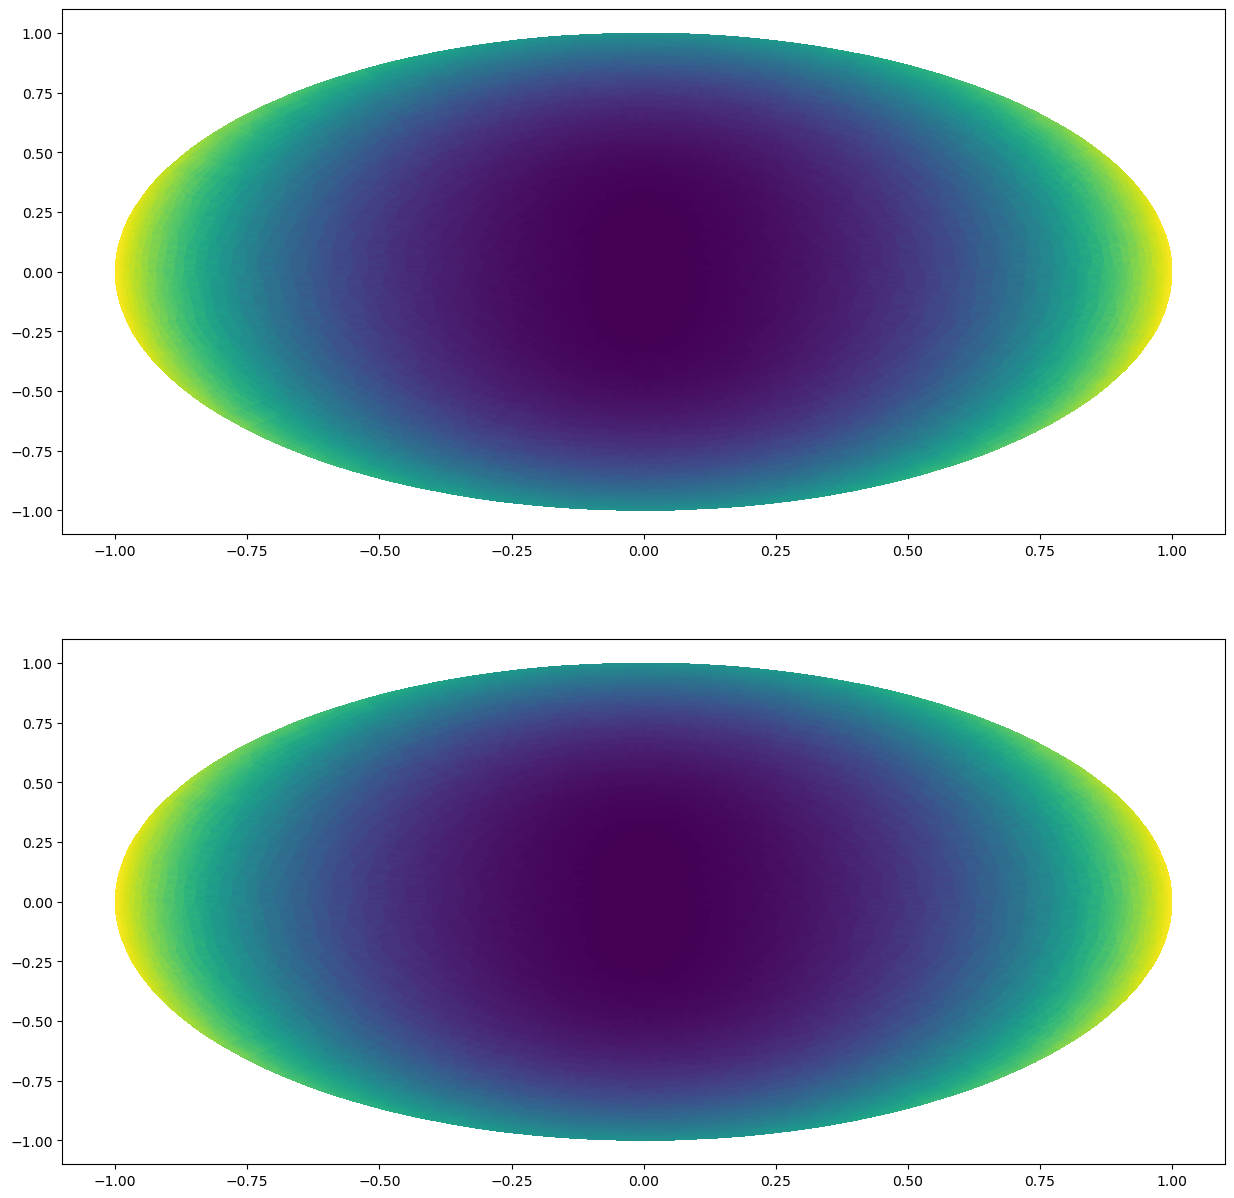

In [4]:
import matplotlib.tri as tri 

triang_chunk = tri.Triangulation(x_down, y_down)

cmap = plt.get_cmap('afmhot')
fig, axes = plt.subplots(2,1, figsize=(15,15)) 

im = axes[0].tripcolor(triang_chunk, np.abs(temperature_down)**2, cmap='viridis')
im = axes[1].tripcolor(triang_chunk, np.abs(temp_down)**2, cmap='viridis')

In [5]:
print(f"temperature_down = {temperature_down[100:110]}")
print(f"temp_down = {temp_down[100:110]}")

print((temperature_down == temp_down).all())


differences = set(temperature_down).symmetric_difference(set(temp_down))
print(temperature_down.shape)
print(len(differences))

temperature_down = [-1.80360541e-06-5.42101086e-20j -6.22435334e-01+6.94333133e-01j
 -9.40040653e-01+8.53284354e-01j -1.62062433e-01+3.54290582e-01j
 -2.25465059e-01-4.17887286e-01j -9.72391422e-01-8.67843322e-01j
 -5.43189172e-01-6.48628329e-01j -6.45994753e-03+7.07268101e-02j
 -6.98521277e-01+7.35546377e-01j -8.96320281e-01+8.33205590e-01j]
temp_down = [-1.80360541e-06-5.42101086e-20j -6.22435334e-01+6.94333133e-01j
 -9.40040653e-01+8.53284354e-01j -1.62062433e-01+3.54290582e-01j
 -2.25465059e-01-4.17887286e-01j -9.72391422e-01-8.67843322e-01j
 -5.43189172e-01-6.48628329e-01j -6.45994753e-03+7.07268101e-02j
 -6.98521277e-01+7.35546377e-01j -8.96320281e-01+8.33205590e-01j]
False
(10000,)
9382


In [6]:
diff = list(zip(np.setdiff1d(temp_down, temperature_down), np.setdiff1d(temperature_down, temp_down))) 
print(diff[10:20])
print(len(diff))

[((-0.9999655280035-0.3747721137380733j), (-0.9999655280035-0.37477211373807334j)), ((-0.9999655173565478+0.9560036149195306j), (-0.9999655173565478+0.9560036149195305j)), ((-0.9999655022600403-0.8165176836124156j), (-0.9999655022600404-0.8165176836124156j)), ((-0.9999654870717503+0.9407422147553077j), (-0.9999654870717501+0.9407422147553076j)), ((-0.9999653891904335-0.08637404029733556j), (-0.9999653891904335-0.08637404029733554j)), ((-0.9999653576916473+0.2797888045741555j), (-0.9999653576916472+0.2797888045741555j)), ((-0.999965331183284+0.465967380571847j), (-0.9999653311832841+0.465967380571847j)), ((-0.9999653243604538-0.6669259271148711j), (-0.9999653243604539-0.6669259271148712j)), ((-0.9999652522999957-0.13433216486731991j), (-0.9999652522999957-0.1343321648673199j)), ((-0.9999652466792905+0.9628015861152152j), (-0.9999652466792903+0.962801586115215j))]
4691
